#### data wrangling

In [3]:
# import packages
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go

df = pd.read_csv("https://media.githubusercontent.com/media/boneeyah/DS7331_Group/main/Data_Files/airbnb_los_angeles.csv")
#df = pd.read_csv("Data_Files/airbnb_los_angeles.csv")

In [4]:
# drop variables which won't be useful for the classification model
for col in [
    'listing_url','scrape_id','last_scraped','description','neighborhood_overview','picture_url','host_url','host_about','host_response_time','host_response_rate','host_acceptance_rate',
    'host_thumbnail_url','host_picture_url','host_verifications','host_has_profile_pic','bathroom_text','host_listings_count','host_neighbourhood','bathrooms','minimum_minimum_nights',
    'maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm','calendar_updated','availability_30','availability_60',
    'availability_90','availability_365','calendar_last_scraped','number_of_reviews_ltm','number_of_reviews_l30d','review_scores_accuracy','review_scores_communication','review_scores_cleanliness',
    'review_scores_checkin','review_scores_value','review_scores_location','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms','reviews_per_month','neighbourhood','neighbourhood_group_cleansed', 'first_review','last_review','minimum_nights','maximum_nights','license','host_total_listings_count'
]:
    if col in df:
        del df[col]

In [5]:
# remove nulls
df = df[~df.review_scores_rating.isnull() & ~df.bathrooms_text.isnull() & ~df.host_since.isnull() & ~df.host_location.isnull()]

## getting property type from string
types = ['Private room', 'Entire', 'Room in hotel','Room','Shared room']
pat = '|'.join(r"\b{}\b".format(x) for x in types)

df['property_type']= df['property_type'].str.extract('('+ pat + ')', expand = False)
df['property_type'] = (df.property_type.
                       fillna(value = 'other').
                       replace(['Entire','Room in hotel'],['Entire unit','Hotel room']))
df['property_type'].value_counts()

Entire unit     22767
Private room     8081
Shared room       510
Room              401
other             298
Hotel room        272
Name: property_type, dtype: int64

In [6]:
# impute values based on median
df['beds'] = df[['accommodates','beds']].groupby(by = 'accommodates').transform(lambda grp: grp.fillna(grp.median()))
df_grouped = df.groupby(by = ['property_type','beds'])
df_imputed = df_grouped[['beds','bedrooms']].transform(lambda grp: grp.fillna(grp.median()))

index = df_imputed[df_imputed.bedrooms.isnull()].index
df = df.drop(index= index)

df['imputed']=df_imputed[['bedrooms']]

# replace 'bedrooms' column with imputed column and deleting the duplicated column
df['bedrooms'] = df['imputed']
del df['imputed']

In [7]:
## now fixing dtypes for attributes
df['host_since'] = pd.to_datetime(df.host_since)
df['price'] = df['price'].replace('[\$,]','',regex = True).astype(float)
df['bathrooms_text'] = df['bathrooms_text'].replace(['Half-bath', 'Shared half-bath', 'Private half-bath'],['0.5 bath','0.5 shared bath', '0.5 private bath'])
df_bathrooms = df['bathrooms_text'].str.split(n=1, expand=True).rename(columns = {0:'bathroom_number',1:'bathroom_type'})
df_bathrooms['bathroom_type'] = df_bathrooms.bathroom_type.fillna(value = 'bath')
df_bathrooms['bathroom_type'] = df_bathrooms['bathroom_type'].replace(['baths','shared baths'],['bath','shared bath'])
df_bathrooms['bathroom_number'] = df_bathrooms['bathroom_number'].astype('float')
df.insert(15, 'bathroom_number',df_bathrooms['bathroom_number'])
df.insert(16, 'bathroom_type', df_bathrooms['bathroom_type'])
del df['bathrooms_text']

In [8]:
### filter out price outliers
df = df[(df.beds<10) & (df.price<750)]

In [9]:
df = df.reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30580 entries, 0 to 30579
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              30580 non-null  int64         
 1   name                            30580 non-null  object        
 2   host_id                         30580 non-null  int64         
 3   host_name                       30580 non-null  object        
 4   host_since                      30580 non-null  datetime64[ns]
 5   host_location                   30580 non-null  object        
 6   host_is_superhost               30580 non-null  object        
 7   host_identity_verified          30580 non-null  object        
 8   neighbourhood_cleansed          30580 non-null  object        
 9   latitude                        30580 non-null  float64       
 10  longitude                       30580 non-null  float64       
 11  pr

In [10]:
# breakdown of categorical variables with number of levels (unique)
df.iloc[:,[1,3,5,6,7,9,12,13,16,19,21,24]].describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,30580.0,33.993072,0.189359,33.33865,33.903087,34.041553,34.099513,34.81326
accommodates,30580.0,3.750621,2.484750,1.00000,2.000000,3.000000,5.000000,16.00000
bedrooms,30580.0,1.616334,0.932373,1.00000,1.000000,1.000000,2.000000,8.00000
price,30580.0,186.166906,141.618829,10.00000,85.000000,140.000000,245.000000,749.00000
number_of_reviews,30580.0,47.849052,81.192747,1.00000,4.000000,15.000000,55.000000,1512.00000
calculated_host_listings_count,30580.0,13.259320,45.123611,1.00000,1.000000,2.000000,7.000000,532.00000


# Create Models


### Rubric Note: Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use a 80/20 train/test split for your data). Adjust parameters of the model to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. THat is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. FOr many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 

In [11]:
# Model will focus on classifying superhost status
# since we're encoding with binary response, we can use labelencoder from sklearn
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['host_is_superhost'] = label_encoder.fit_transform(df['host_is_superhost'])
df.host_is_superhost.value_counts()

0    20236
1    10344
Name: host_is_superhost, dtype: int64

In [12]:
## encoding binary categorical variables
# encode identity verified
df['host_identity_verified'] = label_encoder.fit_transform(df['host_identity_verified'])
df.host_identity_verified.value_counts()

#encode has_availability
df['has_availability'] = label_encoder.fit_transform(df['has_availability'])
df.has_availability.value_counts()

#encode instant bookable
df['instant_bookable'] = label_encoder.fit_transform(df['instant_bookable'])
df.instant_bookable.value_counts()

0    19767
1    10813
Name: instant_bookable, dtype: int64

In [13]:
## changing host_location to a binary feature of is_local using a list of LA area neighborhoods that will be used to extract from location str
#los_angeles = pd.read_csv('Data_Files/LosAngelesNeighborhoods.csv')
los_angeles = pd.read_csv('https://raw.githubusercontent.com/boneeyah/DS7331_Group/main/Data_Files/LosAngelesNeighborhoods.csv')
los_angeles = los_angeles.iloc[:,0].tolist()

pattern = '|'.join(los_angeles)
df['host_is_local'] = df['host_location'].str.contains(pattern)

df['host_is_local'] = label_encoder.fit_transform(df['host_is_local'])


In [14]:
## changing host_since to host_for to get a a numerical variable that corresponds to length in months
## data is from June 6 2022, 06-06-2022
end_date = pd.to_datetime('06-06-2022', format= "%m-%d-%Y")
df['host_for'] = (end_date-df.host_since)/np.timedelta64(1,'M')

df = df.drop(columns= ['host_location', 'host_since']) #drop old host_location and host_since columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30580 entries, 0 to 30579
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              30580 non-null  int64  
 1   name                            30580 non-null  object 
 2   host_id                         30580 non-null  int64  
 3   host_name                       30580 non-null  object 
 4   host_is_superhost               30580 non-null  int32  
 5   host_identity_verified          30580 non-null  int32  
 6   neighbourhood_cleansed          30580 non-null  object 
 7   latitude                        30580 non-null  float64
 8   longitude                       30580 non-null  float64
 9   property_type                   30580 non-null  object 
 10  room_type                       30580 non-null  object 
 11  accommodates                    30580 non-null  int64  
 12  bathroom_number                 

In [15]:
# One Hot Encoding other categorical variables as a non-sparse dataframe
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

df_temp = df[['id','neighbourhood_cleansed','property_type', 'room_type', 'bathroom_type']] # to get only the cat variables


In [16]:
ohe = OneHotEncoder(drop='first',sparse=False)
feature_arr = ohe.fit_transform(df_temp[['neighbourhood_cleansed','property_type', 'room_type', 'bathroom_type']])
feature_labels = ohe.get_feature_names_out()

#create dataframe with features
df_temp = pd.DataFrame(feature_arr, columns= feature_labels)

In [17]:
# drop original columns and join with new onehotencoded columns
df = df.drop(columns = ['neighbourhood_cleansed','property_type', 'room_type', 'bathroom_type','amenities','name','host_name','id','host_id','latitude','longitude']).join(df_temp)


In [18]:
### different method I found first, commented out for now, this could be used to transform within the original dataset saving one step
### but it's easy enough to just fit a new dataframe and then add to original and drop original columns instead
#transformer = make_column_transformer((OneHotEncoder(drop = 'first',sparse=False), ['neighbourhood_cleansed','property_type', 'room_type', 'bathroom_type']), remainder='passthrough')
#df_temp = transformer.fit_transform(df_temp)
#df_temp = pd.DataFrame(df_temp, columns=transformer.get_feature_names_out())
#print(df_temp)

In [19]:
### clean up temporary files
del df_temp, feature_arr, feature_labels

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30580 entries, 0 to 30579
Columns: 325 entries, host_is_superhost to bathroom_type_shared bath
dtypes: float64(317), int32(4), int64(4)
memory usage: 75.4 MB


### Logistic Regression Model

In [23]:
#import packages we'll be using in the model building sections.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix

#dividing dataset into features and labels and using a standard scaler to scale the x values
X = df.loc[:,df.columns != 'host_is_superhost']
X_sc = StandardScaler().fit_transform(X) #scaled X values
X_sc = pd.DataFrame(X_sc,columns=X.columns)
y = df.loc[:, df.columns == 'host_is_superhost']


seed = [10] #seed to be used, it will be assigned as random_state when splitting instead of using np to set seed

In [24]:
### performing 80/20 split using sklearn


cutoff = .63


iter_num =0
for i in seed:
    X_train, X_test, y_train, y_test = train_test_split(X_sc,y, random_state=i, train_size=.8, shuffle=True) #X_train is scaled since X_sc is used for X
    lor_clf = LogisticRegressionCV(cv=10, max_iter = 300, random_state = i)
    lor_clf.fit(X_train, y_train.values.ravel())

    y_hat = lor_clf.predict_proba(X_test)


    response = pd.DataFrame(y_hat, columns=['F','T'])
    y_preds=(response['T']>cutoff).astype('int')

    cm = confusion_matrix(y_test,y_preds, labels=[1,0])
    print('---------Iteration  ',iter_num,'---------')
    print('')
    print('Confusion Matrix')
    print(pd.DataFrame(cm,index= ['True','False'], columns=['True','False']))
    print('________________________________')
    print('accuracy:', (cm[0,0]+cm[1,1])/sum(cm.ravel()))
    print('sensitivity:', cm[0,0]/(cm[0,0]+cm[1,0]))
    print('specificity:', cm[1,1]/(cm[1,1]+cm[0,1]),'\n')
    iter_num=iter_num+1

---------Iteration   0 ---------

Confusion Matrix
       True  False
True    449   1573
False   187   3907
________________________________
accuracy: 0.7122302158273381
sensitivity: 0.7059748427672956
specificity: 0.7129562043795621 



### Support Vector Machine Model

X_sc was scaled using the standard scalar package from sklearn during Logistic Regression and still exists for our use in the SVM Model.  

We'll be using a rbf, or Radial Basis Function, kernel.  RBF determines the similarity between two points and results in a value between 0 and 1, with 0 representing two points that are exactly similar.  However, this kernel doesn't scale well to large data sets.  Our initial suspicion is that we'll have an extended run time for our dataset and may find this model training to be impractical for this exercise.

In [ ]:

from sklearn.svm import SVC
from sklearn import metrics as mt
from matplotlib import pyplot as plt
X_train, X_test, y_train, y_test = train_test_split(X_sc,y, random_state=seed[0], train_size=.8, shuffle=True)#X_test/train is scaled since X_sc is used for X
    
svm_clf = SVC(C=0.5,kernel='rbf',degree =3, gamma='auto', random_state=seed[0])
svm_clf.fit(X_train,y_train.values.ravel())

y_hat = svm_clf.predict(X_test)
acc = mt.accuracy_score(y_test,y_hat)
cm = mt.confusion_matrix(y_test,y_hat, labels=[1,0])
print('Confusion Matrix')
print(pd.DataFrame(cm,index= ['True','False'], columns=['True','False']))
print('________________________________')
print('accuracy:', (cm[0,0]+cm[1,1])/sum(cm.ravel()))
print('sensitivity:', cm[0,0]/(cm[0,0]+cm[1,0]))
print('specificity:', cm[1,1]/(cm[1,1]+cm[0,1]),'\n')

In the code above, we begin by creating a train/test split using the scaled data from before (scaled just prior to the logistic classifier), passing in a seed value assigned earlier, and setting a split of 80/20.  We then create an Support Vector Classifier using the sklearn.SVM package with the SVC class.  We train using the fit function on th etraining data.  We then predict on the test data and use those predictions to score against the actual values.

This results in thg following model performance:

Confusion Matrix

|   | True | False |
| ---- | ----- | ---- |
| True | 563 | 1459 |
| False | 339 | 3755 |

________________________________
| Metric | Value |
| ---- | ---- |
| accuracy: | 0.7060170045781556 |
| sensitivity:| 0.6241685144124168 |
| specificity:| 0.7201764480245493 |

Due to the extended time to train, model tuning was impractical and we felt our best next step was to pursue using the SGDClassifier package, along with a GridSearch to optimize and find the best model.  We'll do that next.

In [25]:
#Try to tune using Grid Search

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
sgd = SGDClassifier()

parameters = {
    'loss':['hinge'],
    'penalty':['l2', 'elasticnet'],
    'n_iter_no_change':[5],
    'l1_ratio':[0.0,0.05,0.06,0.07,0.08,0.09,0.1,0.12,0.13,0.14,0.15,0.2],
    'alpha':[0.1],
    'fit_intercept':[True],
    'learning_rate':['optimal'],
    'n_jobs':[-1],
    'random_state':[seed[0]]
}

sgdGS = GridSearchCV(sgd, parameters, cv=5, verbose=1, n_jobs=1, error_score='raise')

sgdGS.fit(X_train, y_train.values.ravel())

print(sgdGS.best_params_)


#Fitting 5 folds for each of 12 candidates, totalling 60 fits
#{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.0, 'learning_rate': 'optimal', 'loss': 'hinge', 'n_iter_no_change': 5, 'n_jobs': -1, 'penalty': 'l2', 'random_state': 10}

Fitting 5 folds for each of 24 candidates, totalling 120 fits
{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.0, 'learning_rate': 'optimal', 'loss': 'hinge', 'n_iter_no_change': 5, 'n_jobs': -1, 'penalty': 'l2', 'random_state': 10}


Above, we've applied a Grid Search method to determine the best performing model for a SGDClassifier.  We'll use those settings to create a SGD Model below.

In [27]:
#Trying out SGDClassifier to reduce the time to train.

from sklearn import metrics as mt

regularize_const = .1
iterations = 5
#use paramters from gridsearch above
svmSGD = SGDClassifier(alpha=regularize_const, fit_intercept=True, learning_rate='optimal',
                       loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2', random_state=seed[0])

svmSGD.fit(X_train, y_train.values.ravel())
y_hat = svmSGD.predict(X_test)
acc = mt.accuracy_score(y_test,y_hat)
cm = mt.confusion_matrix(y_test,y_hat, labels=[1,0])
print('Confusion Matrix')
print(pd.DataFrame(cm,index= ['True','False'], columns=['True','False']))
print('________________________________')
print('accuracy:', (cm[0,0]+cm[1,1])/sum(cm.ravel()))
print('sensitivity:', cm[0,0]/(cm[0,0]+cm[1,0]))
print('specificity:', cm[1,1]/(cm[1,1]+cm[0,1]),'\n')

Confusion Matrix
       True  False
True    372   1650
False   237   3857
________________________________
accuracy: 0.6914650098103335
sensitivity: 0.6108374384236454
specificity: 0.7003813328491011 



Our SGD Classifier model performance is the following:

This results in thg following model performance:

Confusion Matrix

|   | True | False |
| ---- | ----- | ---- |
| True | 372 | 1650 |
| False | 237 | 3857 |

________________________________
| Metric | Value |
| ---- | ---- |
| accuracy: | 0.6914650098103335 |
| sensitivity:| 0.6108374384236454 |
| specificity:| 0.7003813328491011  |

This was a notable drop, though not excessive, from the SVM Classifier trained above though that ran at roughly 400 times longer than this to train.  In a situation where retraining on new data was frequent, this would be substantial.  Sure, memory and cores could be thrown at this problem now but as the data set grew, such an increase in run time would become unmanagable and impractical quickly.




# Model Advantages

### Rubric Note: Discuss the advantages of each model for each classifciation task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficience? Explain in detail.

Logistic Regression Classifiers have many advantages that make it a simple, effective, and easy to interpret/explain tool for prediction of class.  The output of the preiction is given to the user as a probability of it belonging to a class, making it simple to determine how confident the model is that a prediction is part of the predicted class.  It also returns coefficients that directly relate to the weight given to any feature, including the sign, which implies whether it is a positive or negative weight/influence of the prediction.  This makes for simple intepretation and explainability to even those who don't have experience with common data science tools.

Typically, logistic regression isn't as likely to over fit to a specific data set as other methods can be.  There are also regularization tools such as Lasso and Ridge regression that can help to lower the incidence of over fitting to a data set.



# Interpret Feature Importance

### Rubric Note: Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. WHy do you think some variables are more important?

In [28]:
# coefficient corresponds to the weights, since the data has been scaled (larger absolute values are features of most importance)
importance = pd.DataFrame(lor_clf.coef_.transpose(),index= X.columns.values.tolist(), columns= ['coefficient']).sort_values(ascending=False, by = 'coefficient')
importance = importance[(importance['coefficient']<-.16) | (importance['coefficient']>.16)] # since we have so many variables, this takes the most important
importance

,coefficient
review_scores_rating,1.752343
has_availability,1.171501
number_of_reviews,0.509847
property_type_Private room,0.422575
price,0.211796
neighbourhood_cleansed_Sherman Oaks,0.173913
room_type_Private room,-0.469029


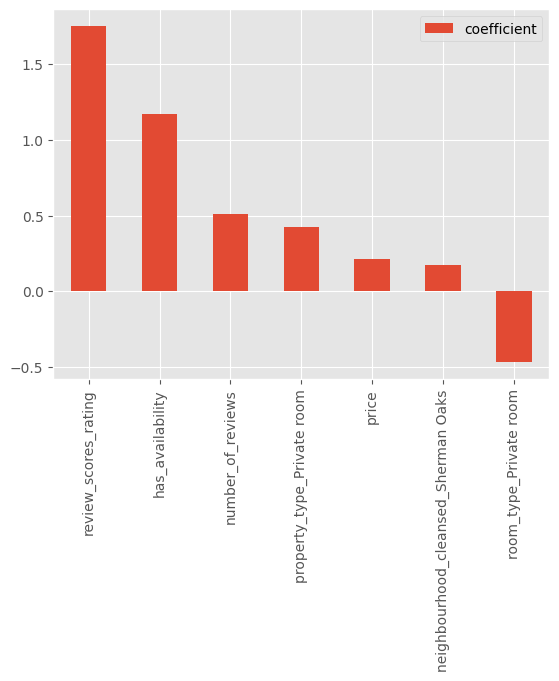

In [29]:
## feature importance for select features, (16 features with the highest positive and negative coefficients)
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = importance.plot(kind='bar')
plt.show()

Due to having several hundred features we narrowed down our search to 10 key features for being a Superhost. For context on a superhost, which is a highly reccomended host for a listing, the requirements are as follows:

Completed at least 10 trips or 3 reservations that total at least 100 nights
Maintained a 90% response rate or higher
Maintained a less than 1% cancellation rate, with exceptions made for those that fall under our Extenuating Circumstances policy
Maintained a 4.8 overall rating (A review counts towards Superhost status when either both the guest and the Host have submitted a review, or the 14-day window for reviews is over, whichever comes first).

The features we found that are the strongest in influencing the probability of becoming a Super Host are review_scores_rating, has_availability, number_of_reviews, property_type_Private room, price, beds, neighbourhood_cleansed_Sherman Oaks, neighbourhood_cleansed_Santa Ana, property_type_Hotel room, room_type_Private room. Review_scores_rating was the highest at 1.721785 and room_type_Private room is the lowest at -0.413266. This indicates that ratings are of utmost imporance in predicting a superhost. Additionally numbers of ratings, availablility, if it's a private room, the price, number of beds and if it's in Sherman Oaks or Santa Ana add influence to that as well. There are also 2 that would negatively affect this as it being a hotel property, or the whole property being a private room. 


# Interpret Support Vectors

### Rubric Note: Look at the chosen support vectors for the classfication task. Do these provide any 8insight into the data? Explain. IF you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model - then analyze the support vectors from the subsampled dataset.

To begin, since we went with a stochastic gradient descent classified due to training time, we'll first look at the features that made up the most importance in that model.  After, we'll attempt to train a SVM Classsifier on a subsample of the original data to see if model performance is acceptable and the time to run component becomes more reasonable.

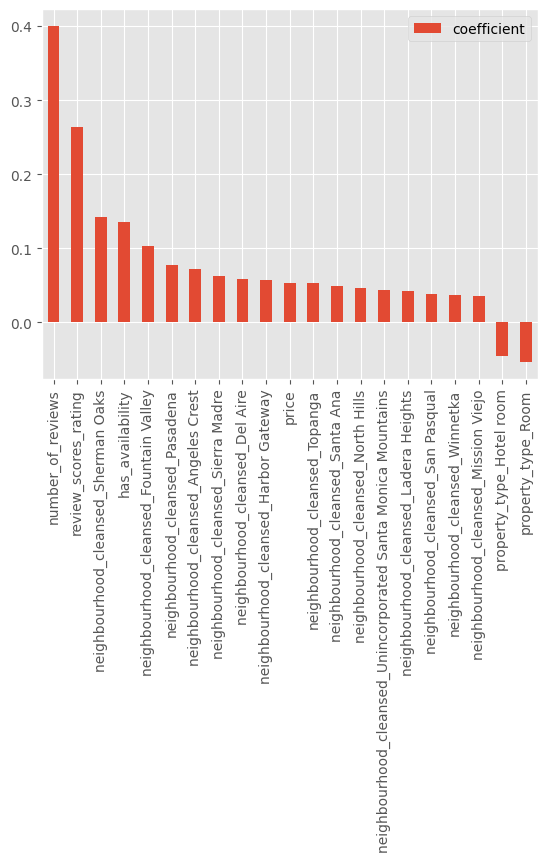

In [30]:
#SGD Feature importance 

# coefficient corresponds to the weights, since the data has been scaled (larger absolute values are features of most importance)
svmImportance = pd.DataFrame(svmSGD.coef_.transpose(),index= X.columns.values.tolist(), columns= ['coefficient']).sort_values(ascending=False, by = 'coefficient')
svmImportance = svmImportance[(svmImportance['coefficient']<-.035) | (svmImportance['coefficient']>.035)] # since we have so many variables, this takes the most important
svmImportance


## feature importance for select features
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

weights = svmImportance.plot(kind='bar')
plt.show()

#### Sub sampling the data set to attempt to train a SVC to identify the support vectors

Because we used an 80/20 train test split, I already have a 20% sub sample in the test.  I will use that as my 'start' sub sample and split that out into a new train test split and use that to train a SVC and identify the support vectors.



In [33]:
#creating a new train/test split using ONLY the test split from before - effectively using a 20% subsample of the data to train an SVC
#make copies of the test split into an X_sub, and y_sub for use in this model

from sklearn.svm import SVC
X_sub = X_test
y_sub = y_test

X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub,y_sub, random_state=seed[0], train_size=.8, shuffle=True)#X_test/train is scaled since X_sc is used for X
    
svm_clf_sub = SVC(C=0.5,kernel='rbf',degree =3, gamma='auto', random_state=seed[0])
svm_clf_sub.fit(X_train_sub,y_train_sub.values.ravel())

y_hat_sub = svm_clf_sub.predict(X_test_sub)
acc = mt.accuracy_score(y_test_sub,y_hat_sub)
cm = mt.confusion_matrix(y_test_sub,y_hat_sub, labels=[1,0])
print('Confusion Matrix')
print(pd.DataFrame(cm,index= ['True','False'], columns=['True','False']))
print('________________________________')
print('accuracy:', (cm[0,0]+cm[1,1])/sum(cm.ravel()))
print('sensitivity:', cm[0,0]/(cm[0,0]+cm[1,0]))
print('specificity:', cm[1,1]/(cm[1,1]+cm[0,1]),'\n')



Confusion Matrix
       True  False
True     60    325
False    43    796
________________________________
accuracy: 0.6993464052287581
sensitivity: 0.5825242718446602
specificity: 0.7100802854594113 



As mentioned above, we want to be able to analyze the support vectors used by a SVM on our data.  To do so, we made the decision to use a 20% subsample of our data.  Because we had already split out the data into an 80/20 training/testing split, we were able to use the test split, already 20%, as a feed into our SVM Classifier model.

We begin by creating a train/test split from that 20% subsample.  We then fit and predict on that mode.

This results in thg following model performance:

Confusion Matrix

|   | True | False |
| ---- | ----- | ---- |
| True | 60 | 325 |
| False | 43 | 796 |

________________________________
| Metric | Value |
| ---- | ---- |
| accuracy: | 0.6993464052287581 |
| sensitivity:| 0.5825242718446602 |
| specificity:|  0.7100802854594113  |

The results show that the performance is in line with the SGD and not too much below the SVC trained and tested with the full dataset.  However, the training time was 50 times less.  This alone gives support to the viability of this model.

Next, we'll look at the instances choosen as support vectors by the support vector classifier.

#### Look at the instances choosen as support vectors

Now that I have an SVM trained on a subsample of the data that is running in about 7 seconds, I will evaluate the instances that were chosen as support vectors.

In [34]:
#extract out the instances as support vectors and plot them
df_tested_on = df.iloc[X_train_sub.index.values,:].copy()
df_support = df_tested_on.iloc[svm_clf_sub.support_,:].copy()


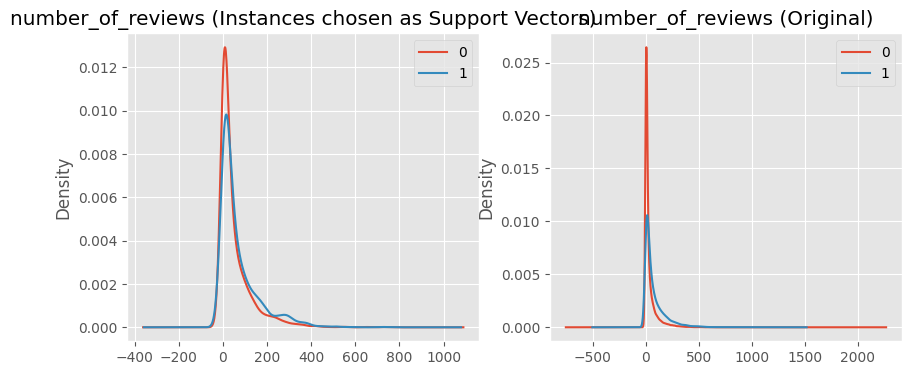

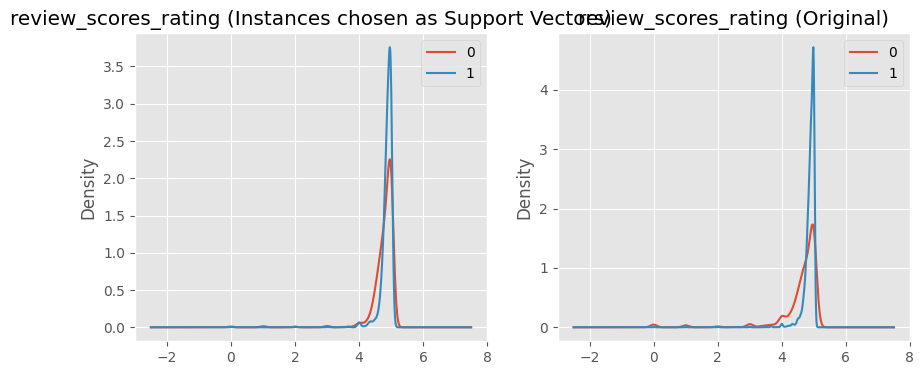

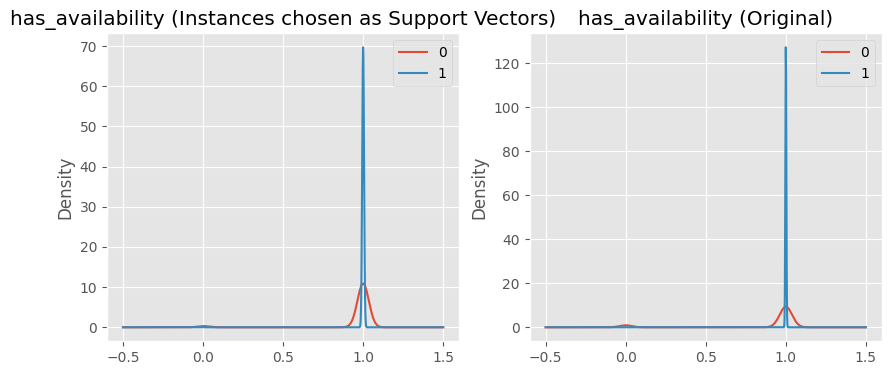

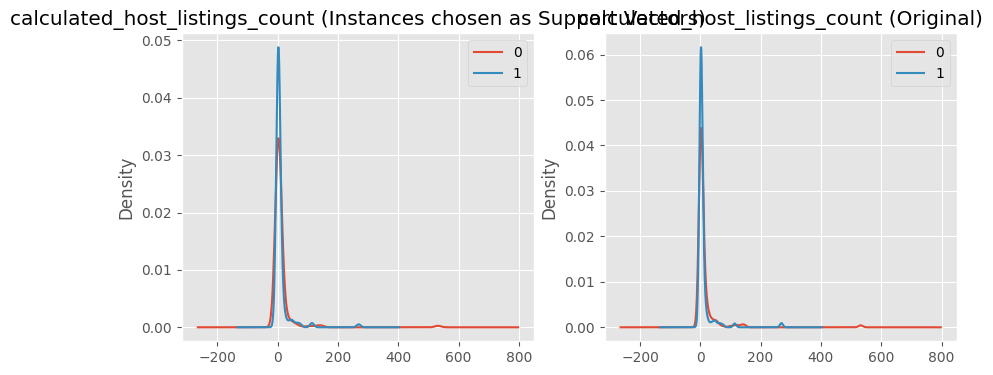

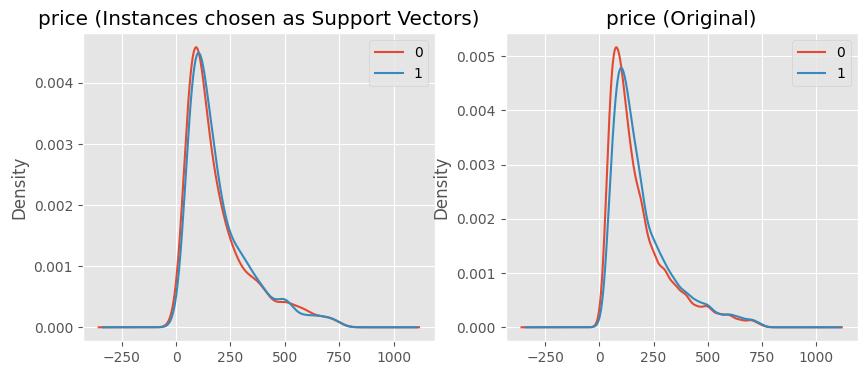

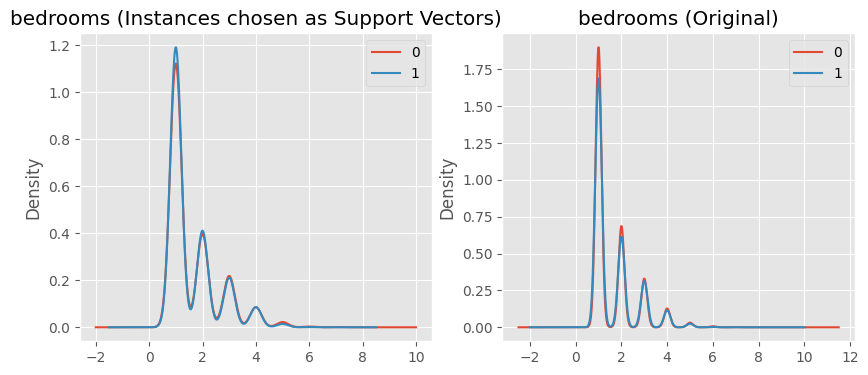

In [35]:
from pandas.plotting import boxplot
df_grouped_support = df_support.groupby(['host_is_superhost'])
df_grouped = df.groupby(['host_is_superhost'])

vars_to_plot = ['number_of_reviews','review_scores_rating','has_availability','calculated_host_listings_count','price','bedrooms']

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend([0,1])
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend([0,1])
    plt.title(v+' (Original)')


#### Evaluating support vectors of the Support Vector Machine Classifier trained on a subsample of the data

In the plots above, for a set of important features, we see on the left the original seperation in the distributions and on the right, that of the chosen support vectors.  We can see overall that the difference in seperation is less in the support vectors than in the original data set.

This is expected as the support vectors typically are chosen due to their similiarity and and even that they may have been predicted incorrectly by the training of the model.